
<table style="width:100%">
    <tr>
        <td><b style="font-size:30px;text-align:left">Guía 3 Segmentación supervisada</b></td>
        <td><b style="font-size:30px"><img src="logo_unab1.jpg" align="right" width="100"/></b></td>
    </tr>
    <tr>
        <td><span style="color:green"><b>Minería de datos empresariales</b></span></td>
    </tr>
</table>

**Descripción de la base de datos**

Trabajeremos con dos bases de datos una de pacientes con o sin Diabetes, y otra con datos de automoviles y sus precios.

# 1. Segmentación supervisada para clasificación

### 1.1 Carga de datos

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

In [76]:
df = pd.read_csv('diabetes_data.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


### 1.2 Mostrar estadísticos asociados a las variables númericas

In [77]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


### 1.3 Análisis de las distribuciones

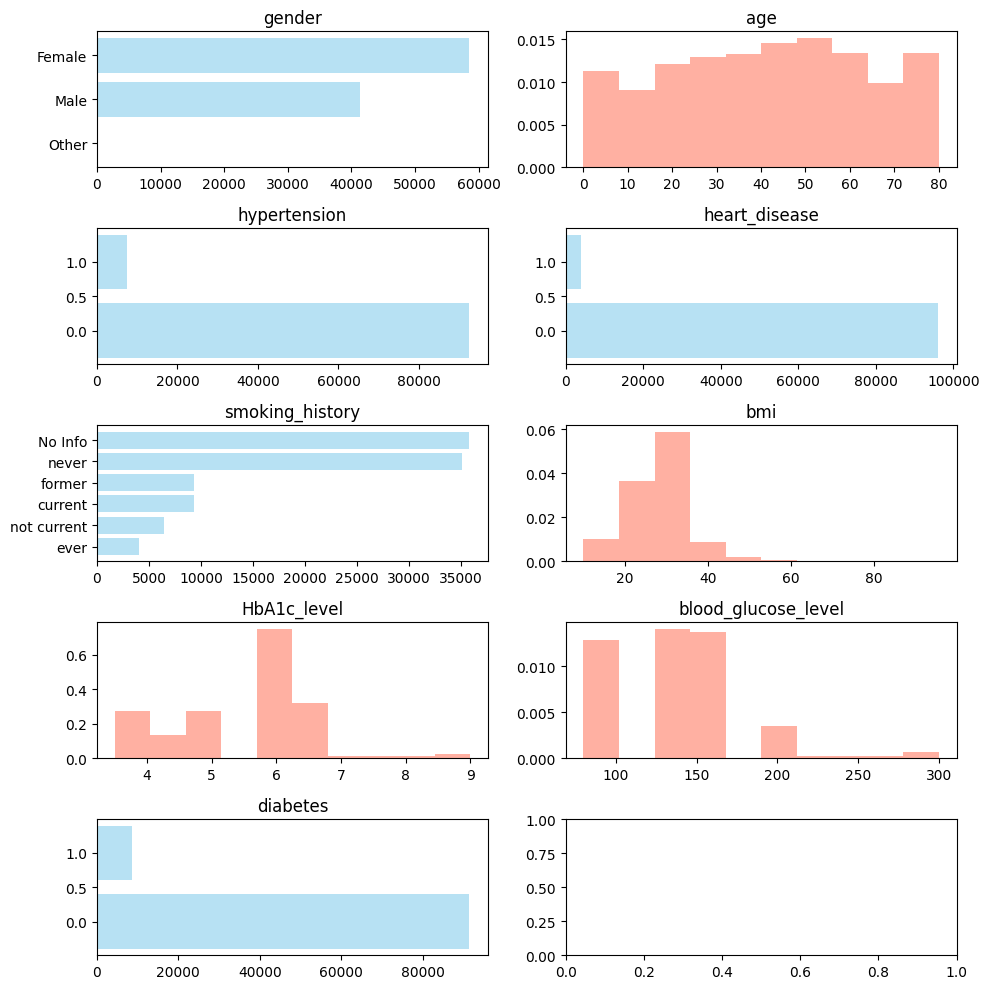

In [78]:

# chart_type = ['hist', 'boxplot']
def describe_plot(df, ncols=4, colors=['skyblue', 'tomato'], figsize=(10, 5), chart_type='hist', umbral=10):
    nrows = int(np.ceil(df.shape[1]/ncols))
    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    for idx, col in enumerate(df.columns):
        i = idx // ncols
        j = idx % ncols

        ncat = len(df[col].unique())
    
        if np.isin(df[col].dtypes, ['O']) | (ncat < umbral):
            cat_count = df[col].value_counts().sort_values()
            ax[i, j].barh(y=cat_count.index, width=cat_count.values, color=colors[0], alpha=.6)
        elif chart_type=='hist':
            ax[i, j].hist(df[col], density=True, color=colors[1], alpha=.5)
        elif chart_type == 'boxplot':
            ax[i, j].boxplot(df[col])
            ax[i, j].set_xticks([])
    
        ax[i, j].set_title(col)
    
    plt.tight_layout()
    plt.show();


describe_plot(df, ncols=2, figsize=(10, 10), chart_type='hist')

### 1.4 Análisis de correlación

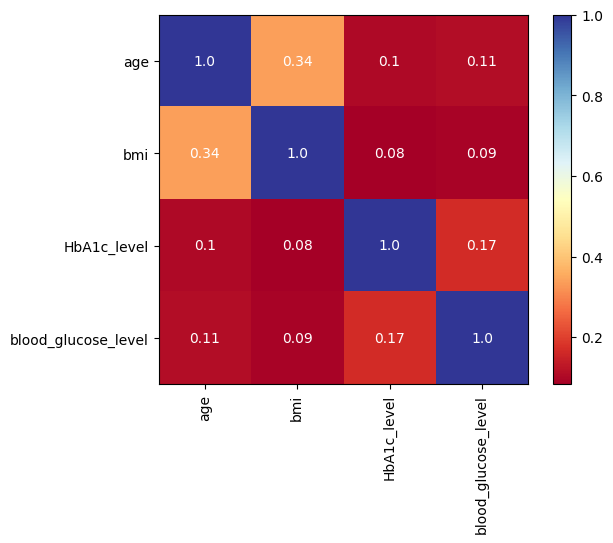

In [79]:
vcontinuas = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
mcorr = df.loc[:, vcontinuas].corr(method='pearson')

_, ax = plt.subplots()
im = ax.imshow(mcorr, cmap='RdYlBu')
cbar = ax.figure.colorbar(im, ax=ax)


ax.set_xticks(np.arange(len(vcontinuas)), labels=vcontinuas, rotation=90)
ax.set_yticks(np.arange(len(vcontinuas)), labels=vcontinuas, rotation=0)

for i in range(len(vcontinuas)):
    for j in range(len(vcontinuas)):
        vcorr = np.round(mcorr.loc[vcontinuas[i], vcontinuas[j]], 2)
        ax.text(i, j, vcorr, ha='center', va='center', color='w')



# sns.heatmap(mcorr, cmap='RdYlBu', annot=True)

### 1.5 Análisis de outliers

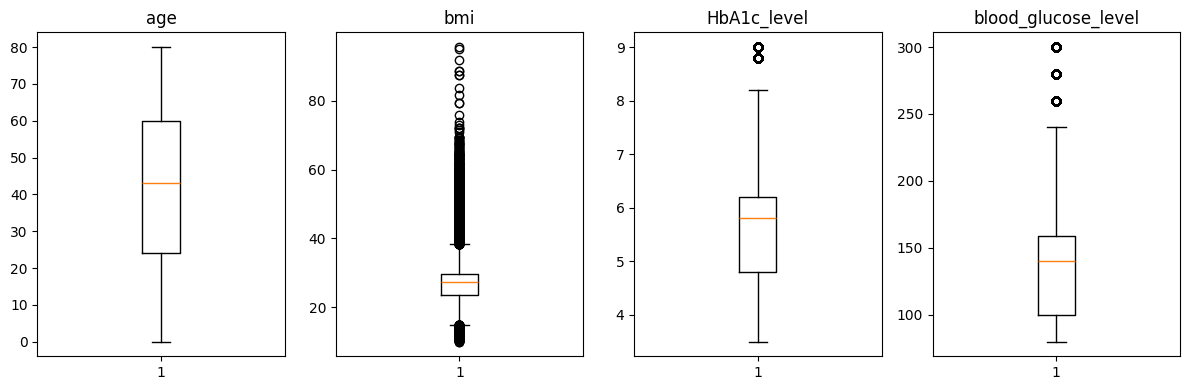

In [80]:
vcontinuas = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
_, ax = plt.subplots(1, 4, figsize=(12, 4))

for idx, col in enumerate(vcontinuas):
    prom = np.mean(df[col])
    ax[idx].boxplot(df[col])
    ax[idx].set_title(col)

plt.tight_layout()
plt.show();

### 1.6 Análisis de distribución de variables continuas con y sin la enfermedad

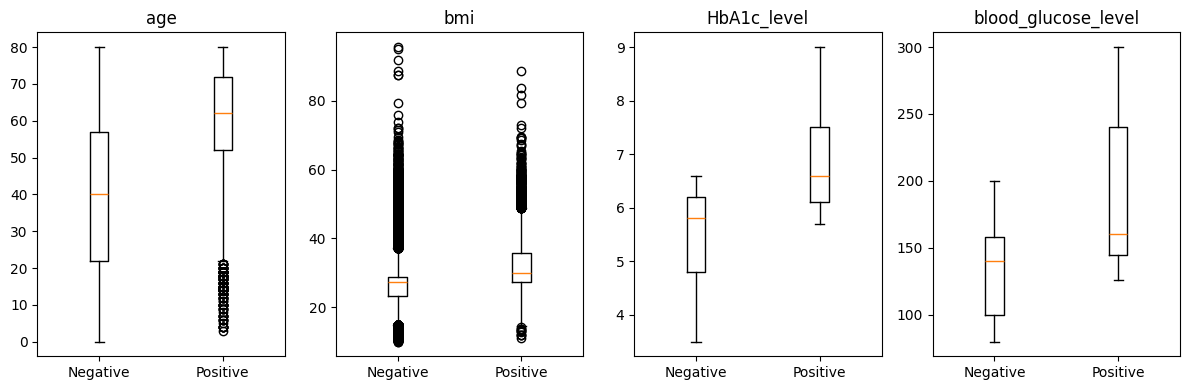

In [82]:
vcontinuas = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
target = 'diabetes'
_, ax = plt.subplots(1, 4, figsize=(12, 4))

lst_cat = df[target].unique()
for i, col in enumerate(vcontinuas):
    aux = [df[df[target]==cat][col] for cat in lst_cat]

    ax[i].boxplot(aux)
    ax[i].set_xticks(range(1, len(lst_cat)+1), 
                     labels=np.where(lst_cat==0, 'Negative', 'Positive'))
    ax[i].set_title(col)

plt.tight_layout()
plt.show();

### 1.7 Crear variables dummies

In [83]:
df = pd.get_dummies(data=df, columns=['gender', 'smoking_history'], drop_first=True, dtype='int')
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,0,0,0,0,0,1,0
1,54.0,0,0,27.32,6.6,80,0,0,0,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,0,1,0,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,0,0,0,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,1,0,1,0,0,0,0


### 1.8 Entrenando un árbol de decisión para clasificación

### 1.8.1 Dividir los datos estrategía Holdout 77% para train y 33% para test

In [84]:
X = df.drop(columns=['diabetes'])
y = df['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)
print(f'Train: {X_train.shape}')
print(f'Test: {X_test.shape}')

Train: (67000, 13)
Test: (33000, 13)


### 1.8.2 Entrenar árbol de decisión con el conjunto de entrenamiento

In [85]:
# creamos la instancia del modelo
dtc_model = DecisionTreeClassifier(max_depth=3, criterion='entropy')

# entrenamos el modelo usando los datos de entrenamiento
dtc_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

### 1.8.3 Dibujar el árbol del modelo entrenado con los datos de entrenamiento "esto cuando se pueda"X

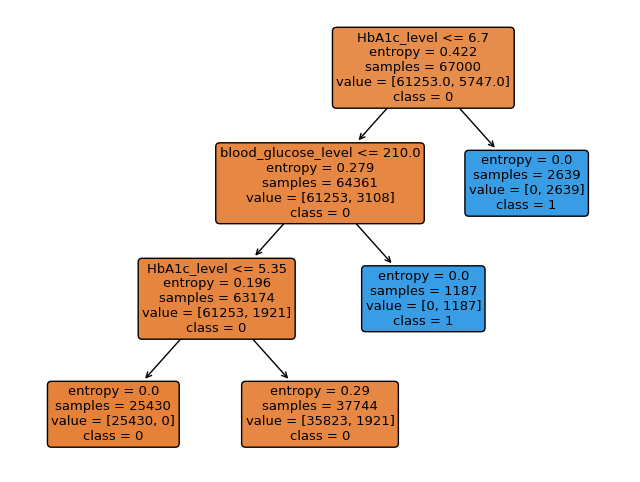

In [86]:
features = X_train.columns
classes = [str(cat) for cat in y_train.unique()]

_, ax = plt.subplots(figsize=(8, 6))

plot_tree(
    dtc_model,
    feature_names=features,
    class_names=classes,
    impurity=True,
    #proportion=True,
    filled=True,
    rounded=True,
    ax=ax,
);

### 1.8.4 Realizar predicciónes usando modelo entrenado para datos que no ha visto el modelo y evaluación métrica accuracy

In [87]:
y_pred = dtc_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Exactitud del modelo: {np.round(accuracy, 2)}')

Exactitud del modelo: 0.97


### 1.8.5 Observaciones mal clasificadas del conjunto de test

In [89]:
X_test2 = X_test.copy()
y_pred = dtc_model.predict(X_test)
X_test2['y_true'] = y_test
X_test2['y_pred'] = y_pred

condition1 = X_test2['y_true'] != X_test2['y_pred']
n_error = len(X_test2[condition1])

print(f'n malclasificada: {n_error}')
X_test2[condition1]

n malclasificada: 892


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,y_true,y_pred
71246,50.0,0,0,29.86,6.5,145,0,0,0,0,0,1,0,1,0
72437,64.0,0,0,42.76,6.1,200,0,0,1,0,0,0,0,1,0
20973,69.0,1,0,31.22,6.6,140,0,0,0,0,0,1,0,1,0
44517,56.0,1,0,41.45,5.8,126,0,0,0,0,0,1,0,1,0
37447,34.0,0,0,27.32,6.5,160,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45329,70.0,0,1,47.55,6.1,145,0,0,1,0,0,0,0,1,0
9896,80.0,0,0,30.28,6.1,145,1,0,0,0,0,0,1,1,0
50210,80.0,0,1,23.72,6.2,145,0,0,0,0,0,1,0,1,0
42539,47.0,1,0,38.66,6.2,130,1,0,1,0,0,0,0,1,0


### 1.8.6 Predicción para un sujeto escogido al azar del conjunto de test

In [416]:
idx_obs_alea = np.random.choice(X_test.index)
np.random.randint(0, X_test.shape[0]-1)
serie = X_test.loc[idx_obs_alea,:]
y_pred = dtc_model.predict(pd.DataFrame([serie]))[0]

print('='*20)
print(f'index: {idx_obs_alea}')
print(serie)
print('='*20)
print()
print(f'Predicción esperada  : {y_test[idx_obs_alea]}')
print(f'Predicción del modelo: {y_pred}')

print('\n')

index: 82206
age                             62.00
hypertension                     0.00
heart_disease                    0.00
bmi                             27.32
HbA1c_level                      4.50
blood_glucose_level            126.00
gender_Male                      0.00
gender_Other                     0.00
smoking_history_current          0.00
smoking_history_ever             0.00
smoking_history_former           0.00
smoking_history_never            0.00
smoking_history_not current      1.00
Name: 82206, dtype: float64

Predicción esperada  : 0
Predicción del modelo: 0




# 2. Segmentación supervisada para regresión

### 2.1 Carga de datos

In [93]:
df2 = pd.read_csv('car_detailscsv.csv')
df2.head()

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,Honda,Amaze 1.2 VX i-VTEC,505000,2017,87150,Petrol,Manual,Pune,Grey,First,Corporate,1198 cc,87 bhp @ 6000 rpm,109 Nm @ 4500 rpm,FWD,3990.0,1680.0,1505.0,5.0,35.0
1,Maruti Suzuki,Swift DZire VDI,450000,2014,75000,Diesel,Manual,Ludhiana,White,Second,Individual,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,FWD,3995.0,1695.0,1555.0,5.0,42.0
2,Hyundai,i10 Magna 1.2 Kappa2,220000,2011,67000,Petrol,Manual,Lucknow,Maroon,First,Individual,1197 cc,79 bhp @ 6000 rpm,112.7619 Nm @ 4000 rpm,FWD,3585.0,1595.0,1550.0,5.0,35.0
3,Toyota,Glanza G,799000,2019,37500,Petrol,Manual,Mangalore,Red,First,Individual,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,FWD,3995.0,1745.0,1510.0,5.0,37.0
4,Toyota,Innova 2.4 VX 7 STR [2016-2020],1950000,2018,69000,Diesel,Manual,Mumbai,Grey,First,Individual,2393 cc,148 bhp @ 3400 rpm,343 Nm @ 1400 rpm,RWD,4735.0,1830.0,1795.0,7.0,55.0


### 2.2 Selección de variables y transformaciones

In [94]:
df_car = df2.drop(columns=['Model', 'Seller Type', 'Max Power', 'Max Torque'])
df_car.shape

(2059, 16)

### 2.3 Eliminación de variables ausentes

In [95]:
df_car = df_car.dropna()
df_car.shape

(1874, 16)

In [96]:
df_car.describe()

,Price,Year,Kilometer,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
count,1.874000e+03,1874.000000,1.874000e+03,1874.000000,1874.000000,1874.000000,1874.000000,1874.000000
mean,1.718279e+06,2016.713447,5.317814e+04,4281.512807,1767.886339,1588.967983,5.295091,52.217343
std,2.426090e+06,3.138477,5.878833e+04,436.220747,131.344883,134.627659,0.807008,15.167250
min,4.900000e+04,1988.000000,0.000000e+00,3099.000000,1475.000000,1213.000000,2.000000,15.000000
25%,5.000000e+05,2015.000000,2.801975e+04,3985.000000,1695.000000,1485.000000,5.000000,42.000000
50%,8.424995e+05,2017.000000,4.879750e+04,4360.000000,1770.000000,1544.000000,5.000000,50.000000
75%,1.908250e+06,2019.000000,7.100000e+04,4620.000000,1831.000000,1670.750000,5.000000,60.000000
max,3.500000e+07,2022.000000,2.000000e+06,5569.000000,2220.000000,1995.000000,8.000000,105.000000


In [97]:
# se convierte la variable Engine en número entero
df_car['Engine'] = df_car['Engine'].str.replace('cc', '').astype('int')
df_car.head()

,Make,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Engine,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,Honda,505000,2017,87150,Petrol,Manual,Pune,Grey,First,1198,FWD,3990.0,1680.0,1505.0,5.0,35.0
1,Maruti Suzuki,450000,2014,75000,Diesel,Manual,Ludhiana,White,Second,1248,FWD,3995.0,1695.0,1555.0,5.0,42.0
2,Hyundai,220000,2011,67000,Petrol,Manual,Lucknow,Maroon,First,1197,FWD,3585.0,1595.0,1550.0,5.0,35.0
3,Toyota,799000,2019,37500,Petrol,Manual,Mangalore,Red,First,1197,FWD,3995.0,1745.0,1510.0,5.0,37.0
4,Toyota,1950000,2018,69000,Diesel,Manual,Mumbai,Grey,First,2393,RWD,4735.0,1830.0,1795.0,7.0,55.0


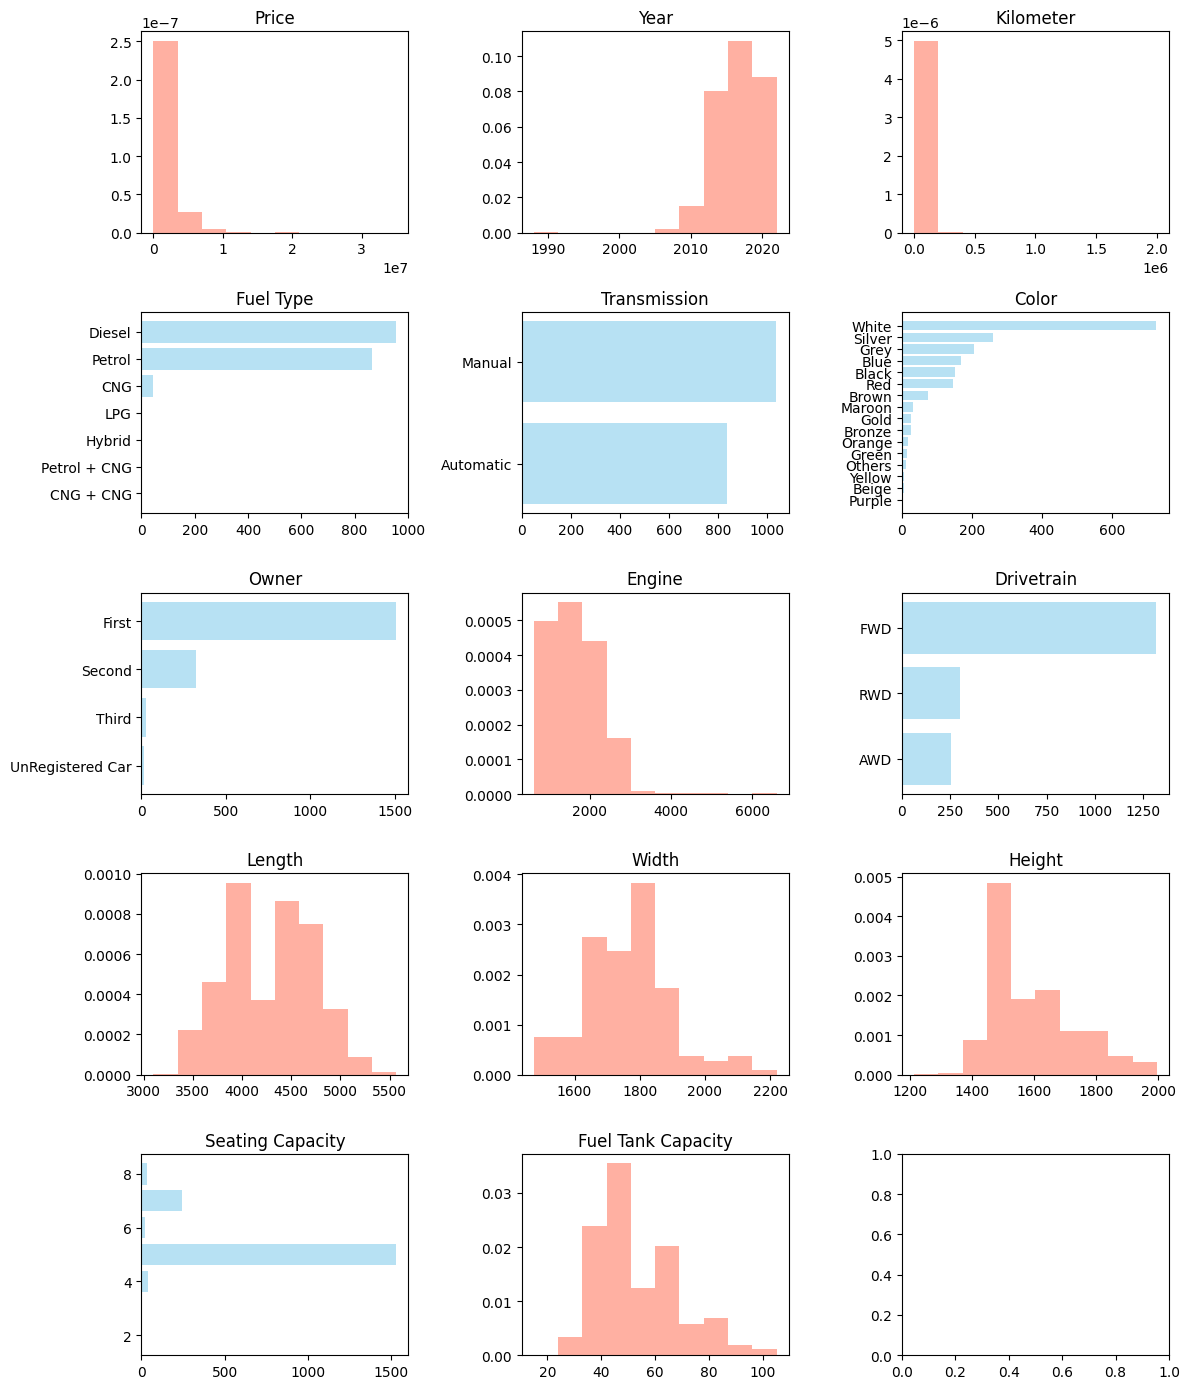

In [98]:
describe_plot(df_car.drop(columns=['Make', 'Location']), ncols=3, figsize=(12, 14), chart_type='hist')

### 2.4 Creación variables ficticias

In [99]:
category_columns = ['Make', 'Fuel Type', 'Transmission', 'Location', 'Color', 'Owner', 'Drivetrain']
df_car = pd.get_dummies(data=df_car, columns=category_columns, drop_first=True, dtype='int')
df_car.head()

,Price,Year,Kilometer,Engine,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,Make_BMW,...,Color_Purple,Color_Red,Color_Silver,Color_White,Color_Yellow,Owner_Second,Owner_Third,Owner_UnRegistered Car,Drivetrain_FWD,Drivetrain_RWD
0,505000,2017,87150,1198,3990.0,1680.0,1505.0,5.0,35.0,0,...,0,0,0,0,0,0,0,0,1,0
1,450000,2014,75000,1248,3995.0,1695.0,1555.0,5.0,42.0,0,...,0,0,0,1,0,1,0,0,1,0
2,220000,2011,67000,1197,3585.0,1595.0,1550.0,5.0,35.0,0,...,0,0,0,0,0,0,0,0,1,0
3,799000,2019,37500,1197,3995.0,1745.0,1510.0,5.0,37.0,0,...,0,1,0,0,0,0,0,0,1,0
4,1950000,2018,69000,2393,4735.0,1830.0,1795.0,7.0,55.0,0,...,0,0,0,0,0,0,0,0,0,1


### 2.5 Entrenando un árbol de decisión para clasificación

### 2.5.1 Dividir los datos estrategía Holdout 77% para train y 33% para test

In [100]:
X = df_car.drop(columns=['Price'])
y = df_car['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)
print(f'Train: {X_train.shape}')
print(f'Test: {X_test.shape}')

Train: (1255, 140)
Test: (619, 140)


### 2.5.2 Entrenar árbol de decisión con el conjunto de entrenamiento

In [120]:
# creamos la instancia del modelo
dtr_model = DecisionTreeRegressor(max_depth=2)

# entrenamos el modelo usando los datos de entrenamiento
dtr_model.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=2)

### 2.5.3 Dibujar el árbol del modelo entrenado con los datos de entrenamiento "esto cuando se pueda"X

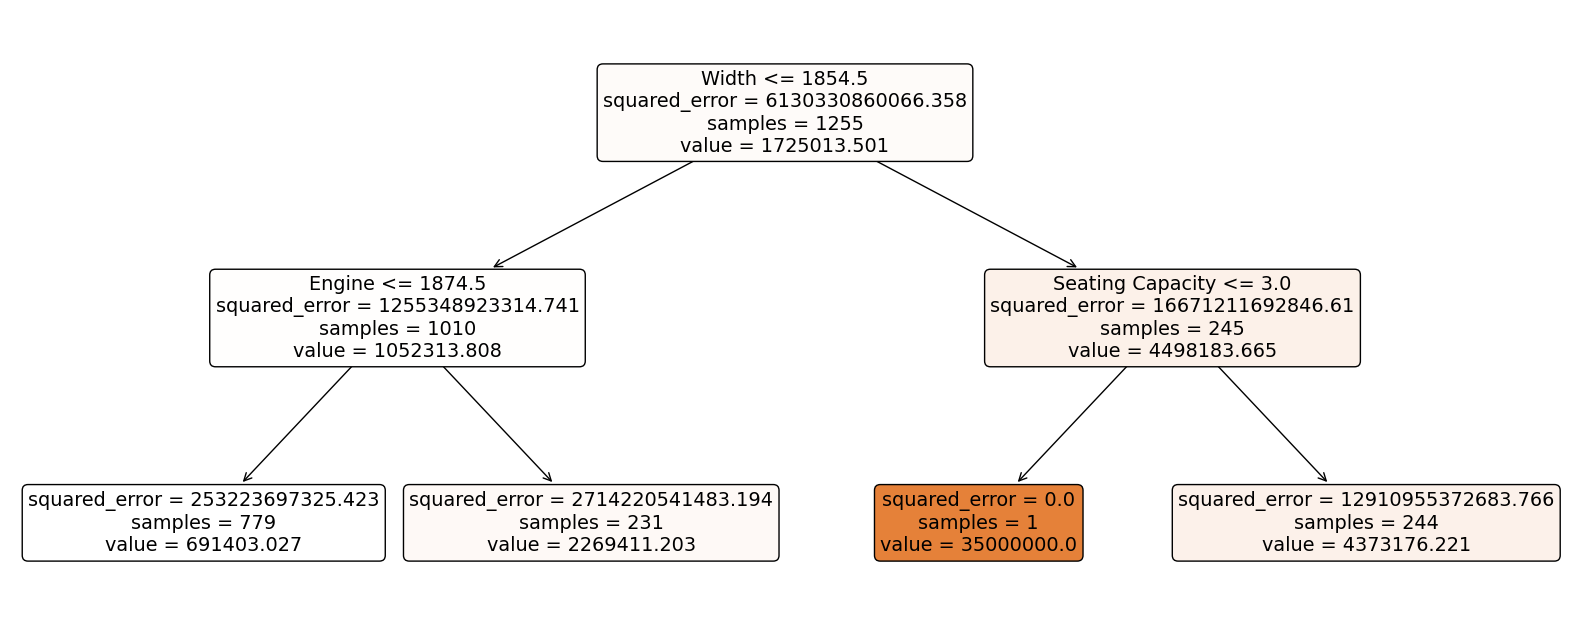

In [123]:
features = X_train.columns
classes = [str(cat) for cat in y_train.unique()]

_, ax = plt.subplots(figsize=(20, 8))

plot_tree(
    dtr_model,
    feature_names=features,
    class_names=classes,
    impurity=True,
    #proportion=True,
    filled=True,
    rounded=True,
    ax=ax,
);

### 2.6 Realizar predicciónes usando modelo entrenado para datos que no ha visto el modelo y evaluación métrica accuracy

In [115]:
y_pred = dtr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'MSE: {np.round(mse, 2)}')
print(f'MAE: {np.round(mae, 2)}')

MSE: 922796691640.38
MAE: 437731.32


### 2.7 Predicción para un sujeto escogido al azar del conjunto de test

In [118]:
idx_obs_alea = np.random.choice(X_test.index)
np.random.randint(0, X_test.shape[0]-1)
serie = X_test.loc[idx_obs_alea,:]
y_pred = dtr_model.predict(pd.DataFrame([serie]))[0]

print('='*20)
print(f'index: {idx_obs_alea}')
print(serie)
print('='*20)
print()
print(f'Predicción esperada  : {y_test[idx_obs_alea]}')
print(f'Predicción del modelo: {y_pred}')

print('\n')

index: 1945
Year                       2014.0
Kilometer                 65123.0
Engine                     1582.0
Length                     4370.0
Width                      1700.0
                           ...   
Owner_Second                  0.0
Owner_Third                   0.0
Owner_UnRegistered Car        0.0
Drivetrain_FWD                1.0
Drivetrain_RWD                0.0
Name: 1945, Length: 140, dtype: float64

Predicción esperada  : 595000
Predicción del modelo: 489169.58928571426


